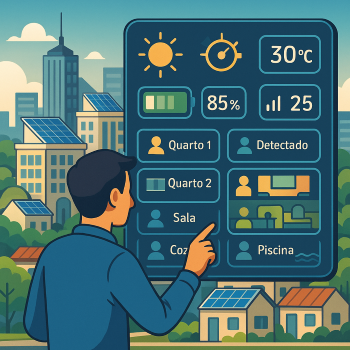

🎯 Objetivo do Projeto

Desenvolver uma solução baseada em ciência de dados e inteligência artificial para monitorar, prever e otimizar o consumo de energia elétrica em uma residência inteligente (Smart City Laguna). O projeto simula dados de sensores por cômodo e utiliza aprendizado de máquina para antecipar padrões de consumo e propor ações de economia.

🔍 Pergunta de Negócio

Como podemos monitorar e prever o consumo de energia de uma residência inteligente com base em dados simulados de sensores por cômodo, a fim de propor ações para redução e eficiência energética?

🗂️ Base de Dados

Utilizamos uma base de dados simulada contendo informações diárias de consumo total de energia (kWh), além dos acionamentos de sensores em cômodos específicos da casa (Quarto1, Quarto2, Sala, Cozinha, Piscina).

🔬 O que foi testado

Foi testado um modelo de regressão linear para prever o consumo diário de energia com base na quantidade de acionamentos nos cômodos. Também exploramos visualizações para identificar os cômodos de maior impacto no consumo.

🧹 Pré-processamento de Dados

Os dados foram carregados, convertidos em formatos apropriados (por exemplo, data para datetime), e foram criadas variáveis auxiliares como 'dia ordinal'. Também foi normalizado o consumo por acionamento.

📊 Interpretação dos Gráficos

Os gráficos demonstram a evolução temporal do consumo, a contribuição relativa de cada cômodo, e previsões futuras com base nos acionamentos. Também foi gerado um ranking de cômodos mais consumidores.



📈 Conclusões

O consumo está fortemente correlacionado com os acionamentos em sala e cozinha.
O modelo de regressão mostrou boa capacidade preditiva para consumo futuro.
Cômodos como a piscina apresentam alto consumo mesmo com poucos acionamentos, indicando oportunidades de economia

Análise e Otimização do Consumo de Energia Residencial por Ambiente



In [34]:
import locale
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#--------------------------------------------------
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [35]:
# Carregar o arquivo Excel com múltiplas abas
file_path = "/Users/fabicampanari/Desktop/Project Planet Smart City Laguna/2-CRISP-DM - Project Smart City Laguna/🇧🇷 CRISP-DM_Projeto_Smart_City_Laguna/Consumo_de_Energia_Analise.xlsx"
xls = pd.ExcelFile(file_path)

# Listar os nomes das abas
sheet_names = xls.sheet_names
sheet_names

['Sheet1']

In [36]:
# Carregar os dados da aba "Sheet1"
df = xls.parse('Sheet1')

# Exibir as primeiras linhas para análise inicial
df

,Data,KW/H,Quarto1,Quarto2,Sala,Cozinha,Piscina
0,01/jan,1395,10,8,15,16,9
1,02/jan,1086,9,8,10,6,10
2,03/jan,1174,10,11,9,13,6
3,04/jan,1207,6,8,10,8,16
4,05/jan,1036,13,4,10,8,8
...,...,...,...,...,...,...,...
206,26/jul,1355,12,12,12,10,6
207,27/jul,1533,14,12,16,13,10
208,28/jul,967,4,9,8,8,9
209,29/jul,1416,14,10,13,8,10


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Data     211 non-null    object
 1   KW/H     211 non-null    int64 
 2   Quarto1  211 non-null    int64 
 3   Quarto2  211 non-null    int64 
 4   Sala     211 non-null    int64 
 5   Cozinha  211 non-null    int64 
 6   Piscina  211 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 11.7+ KB


In [38]:
meses_pt = {
    'jan': '01',
    'fev': '02',
    'mar': '03',
    'abr': '04',
    'mai': '05',
    'jun': '06',
    'jul': '07',

}

# Força o tipo string
df['Data'] = df['Data'].astype(str)

# Substitui os meses por números
df['Data'] = df['Data'].str.lower().replace(meses_pt, regex=True)

# Adiciona o ano e converte para datetime
df['Data'] = pd.to_datetime(df['Data'] + '/2025', format='%d/%m/%Y')


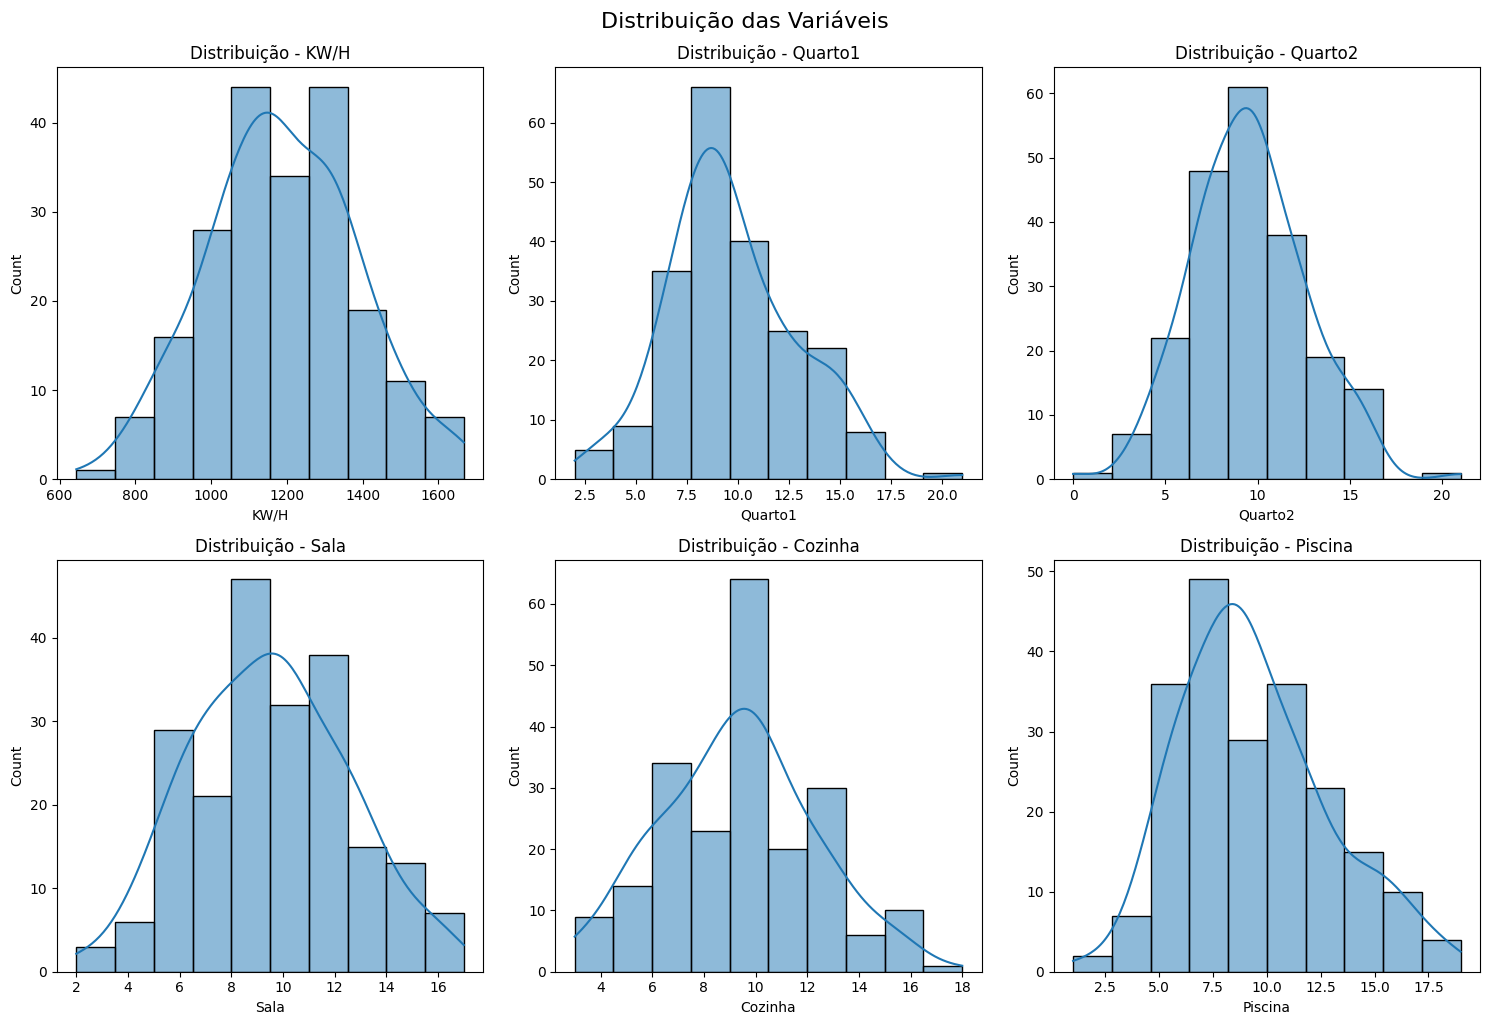

(                      Data         KW/H     Quarto1     Quarto2        Sala  \
 count                  211   211.000000  211.000000  211.000000  211.000000   
 mean   2025-04-16 00:00:00  1188.317536    9.687204    9.549763    9.445498   
 min    2025-01-01 00:00:00   644.000000    2.000000    0.000000    2.000000   
 25%    2025-02-22 12:00:00  1057.000000    8.000000    7.000000    7.000000   
 50%    2025-04-16 00:00:00  1176.000000    9.000000    9.000000    9.000000   
 75%    2025-06-07 12:00:00  1324.000000   12.000000   11.500000   12.000000   
 max    2025-07-30 00:00:00  1667.000000   21.000000   21.000000   17.000000   
 std                    NaN   197.439318    3.176817    3.073874    3.033247   
 
           Cozinha     Piscina  
 count  211.000000  211.000000  
 mean     9.322275    9.383886  
 min      3.000000    1.000000  
 25%      7.000000    7.000000  
 50%      9.000000    9.000000  
 75%     11.000000   11.000000  
 max     18.000000   19.000000  
 std      2.96

In [39]:
# Estatísticas descritivas
summary = df.describe()

# Correlação entre as variáveis
correlation = df.corr(numeric_only=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

cols = df.columns[1:7]  # pega só 6 colunas

for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=10)
    axes[i].set_title(f'Distribuição - {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()

plt.suptitle("Distribuição das Variáveis", fontsize=16, y=1.02)
plt.show()

summary, correlation

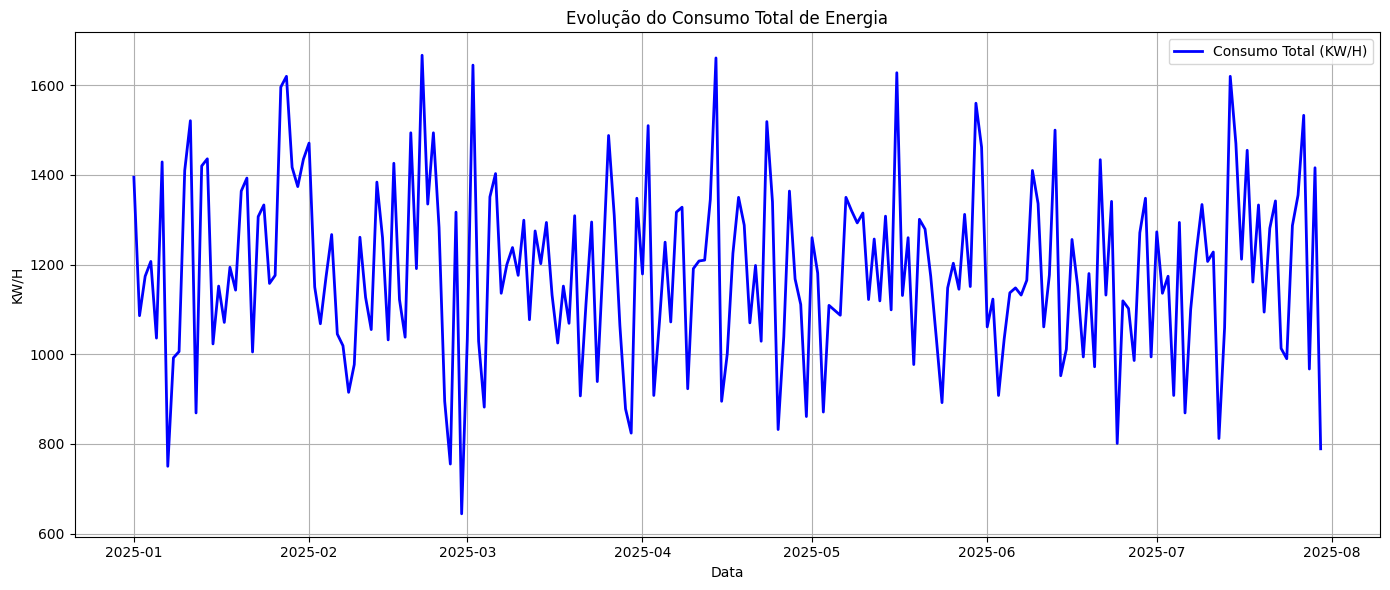

In [40]:
# Plotar consumo total ao longo do tempo
plt.figure(figsize=(14, 6))
plt.plot(df['Data'], df['KW/H'], label='Consumo Total (KW/H)', color='blue', linewidth=2)
plt.title('Evolução do Consumo Total de Energia')
plt.xlabel('Data')
plt.ylabel('KW/H')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

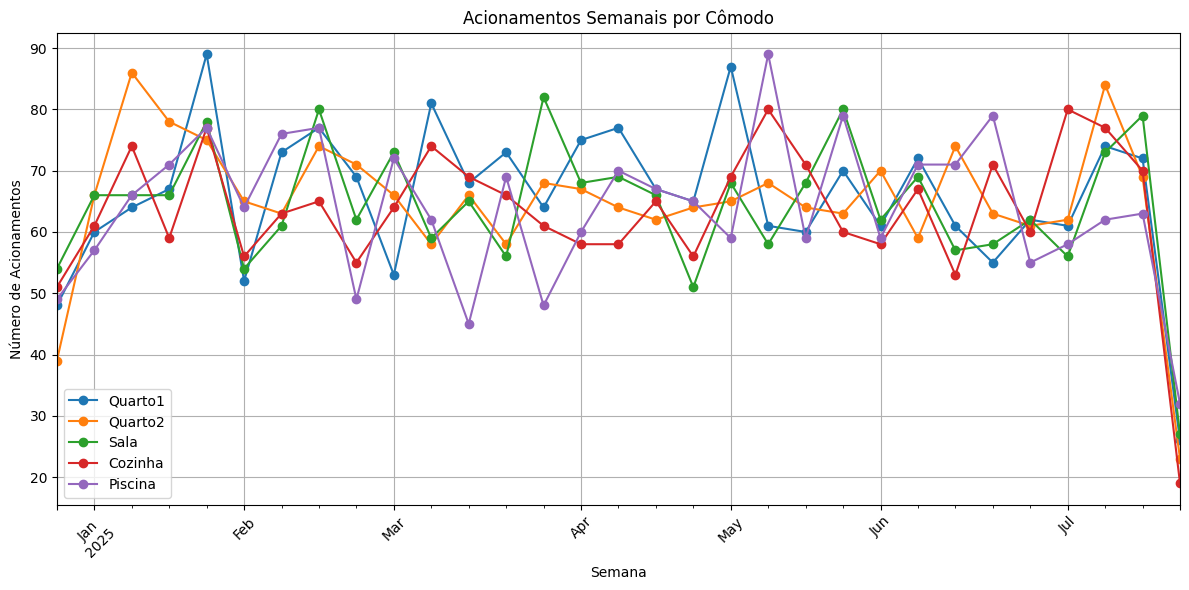

In [41]:
# Agrupa por semana (usando o início da semana como referência)
df['Semana'] = df['Data'].dt.to_period('W').apply(lambda r: r.start_time)
df_semana = df.groupby('Semana')[['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']].sum()
df
# Plot
df_semana.plot(figsize=(12, 6), marker='o')
plt.title('Acionamentos Semanais por Cômodo')
plt.ylabel('Número de Acionamentos')
plt.xlabel('Semana')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/sp/qr0jn46s10x5j0y77wb390d00000gn/T/ipykernel_60313/3101124598.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.index, y=correlacoes.values, palette='Oranges_r')


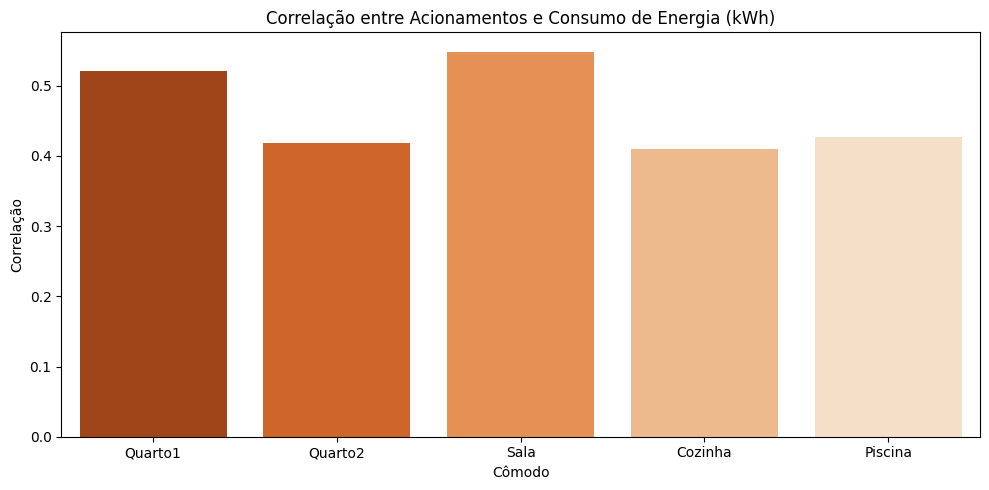

In [42]:
# Correlação entre acionamentos e consumo
correlacoes = df[['KW/H', 'Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']].corr()['KW/H'][1:]

# Gráfico: Correlação com consumo
plt.figure(figsize=(10, 5))
sns.barplot(x=correlacoes.index, y=correlacoes.values, palette='Oranges_r')
plt.title('Correlação entre Acionamentos e Consumo de Energia (kWh)')
plt.ylabel('Correlação')
plt.xlabel('Cômodo')
plt.tight_layout()
plt.show()

Erro quadrático médio (MSE): 11528.06
Coeficiente de determinação (R²): 0.7


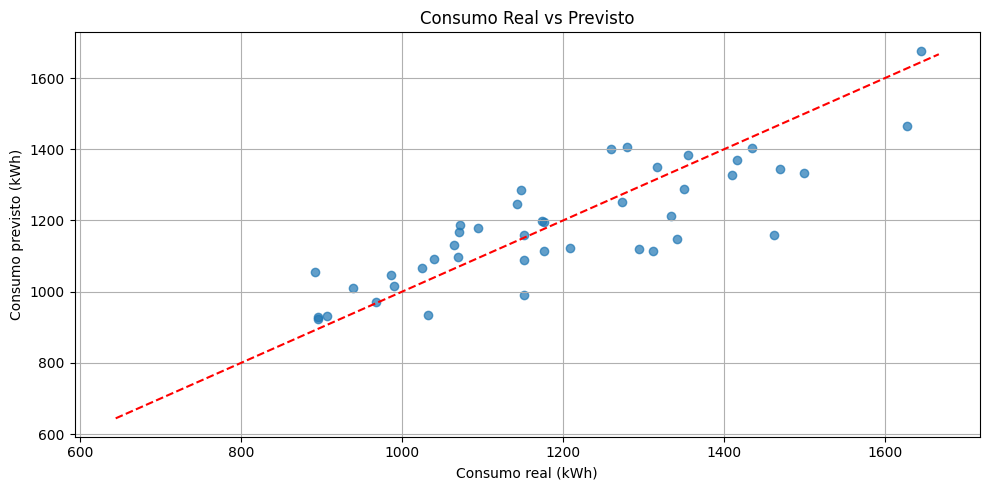


Contribuição de cada cômodo na previsão (coeficientes):
Sala       28.214005
Quarto2    24.141777
Quarto1    23.279552
Cozinha    20.993133
dtype: float64


In [43]:
from sklearn.metrics import mean_squared_error

# 2. Selecionar variáveis
X = df[['Quarto1', 'Quarto2', 'Sala', 'Cozinha']]
y = df['KW/H']

# 3. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Treinar modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 5. Fazer previsões
y_pred = modelo.predict(X_test)

# 6. Avaliar modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erro quadrático médio (MSE):", round(mse, 2))
print("Coeficiente de determinação (R²):", round(r2, 2))

# 7. Visualizar: consumo real vs previsto
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Consumo real (kWh)")
plt.ylabel("Consumo previsto (kWh)")
plt.title("Consumo Real vs Previsto")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Mostrar coeficientes de cada cômodo
coeficientes = pd.Series(modelo.coef_, index=X.columns)
print("\nContribuição de cada cômodo na previsão (coeficientes):")
print(coeficientes.sort_values(ascending=False))

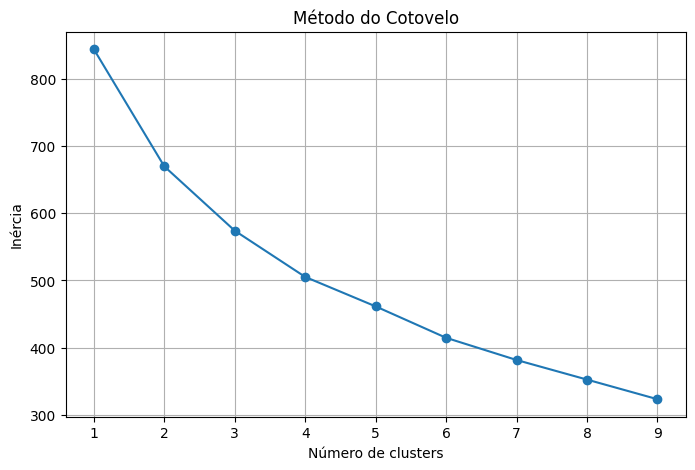

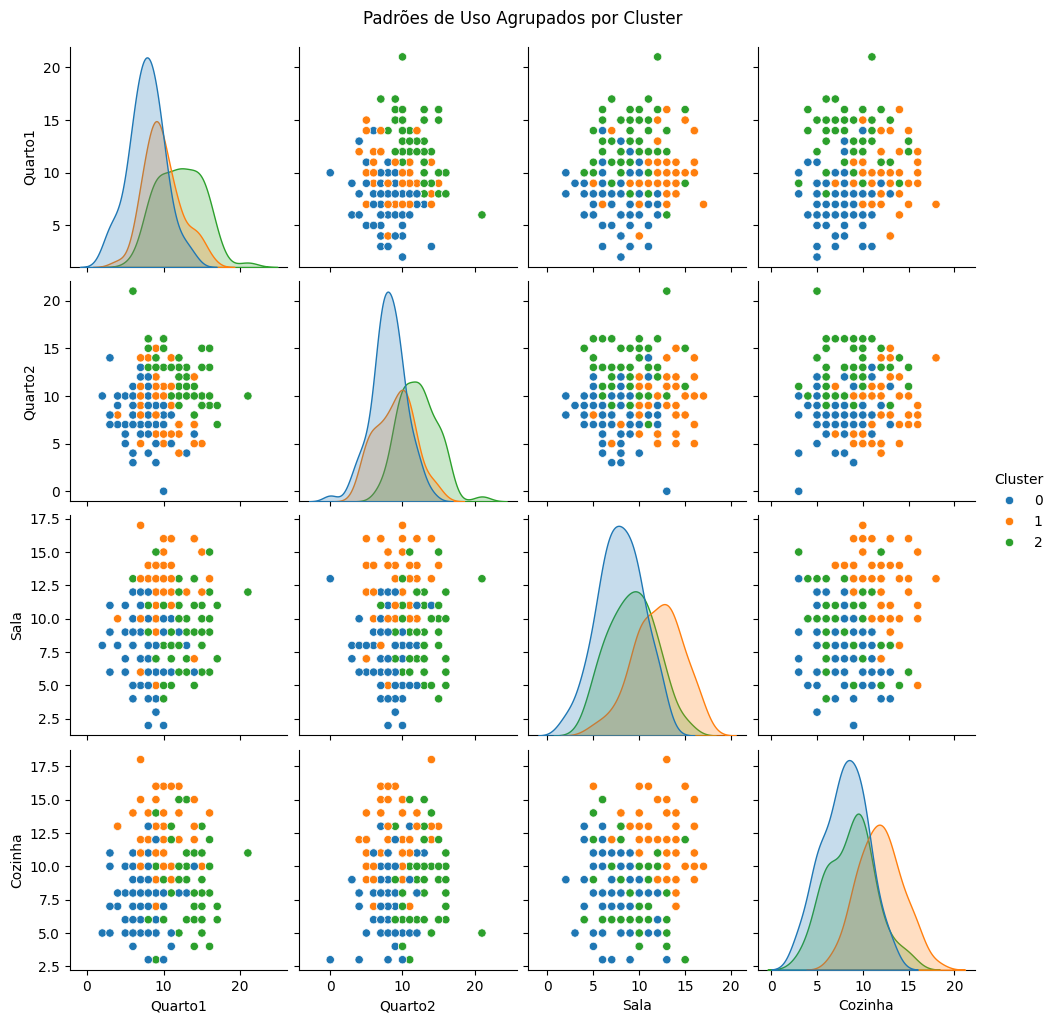

In [44]:
# --- Passo 1: Calcular total e percentual de acionamentos por dia
df['Total_acionamentos'] = df[['Quarto1', 'Quarto2', 'Sala', 'Cozinha']].sum(axis=1)
for comodo in ['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']:
    df[f'{comodo}_pct'] = df[comodo] / df['Total_acionamentos']


# Normalização (muito importante para KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Método do Cotovelo para achar o número ideal de clusters
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

# Pelo gráfico você escolhe o número de clusters; aqui vamos usar 3
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualização dos clusters (pareamento de variáveis)
sns.pairplot(df, hue='Cluster', vars=['Quarto1', 'Quarto2', 'Sala', 'Cozinha'], palette='tab10')
plt.suptitle("Padrões de Uso Agrupados por Cluster", y=1.02)
plt.show()


In [45]:
# Aplicar KMeans com o número de clusters escolhido
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Calcular perfil médio por cluster (com acionamentos e percentuais)
col_pcts = [f'{c}_pct' for c in ['Quarto1', 'Quarto2', 'Sala', 'Cozinha']]
perfil_clusters = df.groupby('Cluster')[['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'KW/H'] + col_pcts].mean()

# Função para nomear o perfil dos clusters considerando consumo e percentual de acionamentos
def nomear_cluster(row):
    media_kw = df['KW/H'].mean()

    if row['KW/H'] < media_kw * 0.75:
        consumo_total = '🔵 Baixo Consumo'
    elif row['KW/H'] > media_kw * 1.25:
        consumo_total = '🔴 Alto Consumo'
    else:
        consumo_total = '🟡 Consumo Equilibrado'

    altos = []
    for comodo in ['Quarto1', 'Quarto2', 'Sala', 'Cozinha']:
        media_pct = df[f'{comodo}_pct'].mean()
        if row[f'{comodo}_pct'] > media_pct * 1.2:  # 20% acima da média percentual
            altos.append(comodo)

    if consumo_total == '🔵 Baixo Consumo':
        return consumo_total
    if consumo_total == '🟡 Consumo Equilibrado':
        if len(altos) == 0:
            return consumo_total
        else:
            return f"🟠 Consumo Elevado em {', '.join(altos)}"
    if consumo_total == '🔴 Alto Consumo':
        if len(altos) == 0:
            return consumo_total
        else:
            return f"🔴 Alto Consumo (Em {', '.join(altos)})"

perfil_clusters['Perfil'] = perfil_clusters.apply(nomear_cluster, axis=1)

# Função para mapear perfil para chave do dicionário de recomendações
def mapear_perfil_para_chave(perfil):
    if perfil == '🔵 Baixo Consumo':
        return perfil
    if perfil == '🟡 Consumo Equilibrado':
        return perfil
    if perfil.startswith('🟠 Consumo Elevado'):
        return '🟠 Consumo Elevado'
    if perfil.startswith('🔴 Alto Consumo'):
        if 'Em' in perfil:
            idx = perfil.index('Em') + 3
            texto = perfil[idx:]
            principal = texto.split(',')[0].strip()
            if principal in ['Sala']:
                return '🔴 Alto Consumo (Sala/Cozinha)'
            elif principal == 'Cozinha':
                return '🔴 Alto Consumo (Cozinha)'
            else:
                return '🔴 Alto Consumo'
        else:
            return '🔴 Alto Consumo'
    return perfil

# Dicionário com recomendações por perfil
recomendacoes = {
    '🔵 Baixo Consumo': [
        "✅ Manter boas práticas já adotadas.",
        "🎁 Oferecer recompensas ou descontos (gamificação).",
        "🔋 Incentivar uso de energia solar / microgeração."
    ],
    '🟡 Consumo Equilibrado': [
        "🔌 Automatizar desligamento de equipamentos em horários fixos.",
        "🕵️ Instalar sensores de presença em quartos e sala.",
        "📊 Enviar relatórios semanais de uso comparativo."
    ],
    '🟠 Consumo Elevado': [
        "🛏️ Automatizar luzes e eletrônicos nos cômodos com consumo elevado.",
        "🕵️ Instalar sensores de presença específicos para os cômodos.",
        "📊 Acompanhar o uso para identificar picos desnecessários."
    ],
    '🔴 Alto Consumo (Sala/Cozinha)': [
        "💧 Agendar funcionamento da bomba da Cozinha fora do pico.",
        "💡 Incentivar uso consciente da iluminação e eletrônicos.",
        "🧠 Sugerir automação e adesão à tarifa branca."
    ],
    '🔴 Alto Consumo (Cozinha)': [
        "🍳 Verificar equipamentos de cozinha para consumo excessivo.",
        "⏰ Controlar horários de uso de forno e geladeira.",
        "💡 Incentivar uso eficiente da iluminação."
    ]
}

# Exibir perfis e recomendações
for cluster_id, row in perfil_clusters.iterrows():
    print(f"\n=== Cluster {cluster_id} - {row['Perfil']} ===")
    print("📊 Perfil médio de consumo (acionamentos e kWh):")
    print(row[['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'KW/H']])
    print("\n📈 Percentual médio de acionamentos por cômodo (%):")
    print((row[col_pcts] * 100).round(2))
    print("\n💡 Recomendações:")
    chave = mapear_perfil_para_chave(row['Perfil'])
    if chave in recomendacoes:
        for rec in recomendacoes[chave]:
            print("-", rec)
    else:
        print("- Sem recomendações específicas para este perfil.")




=== Cluster 0 - 🟡 Consumo Equilibrado ===
📊 Perfil médio de consumo (acionamentos e kWh):
Quarto1       7.747126
Quarto2       8.034483
Sala          7.908046
Cozinha       8.011494
KW/H       1047.402299
Name: 0, dtype: object

📈 Percentual médio de acionamentos por cômodo (%):
Quarto1_pct    24.481434
Quarto2_pct    25.376404
Sala_pct       24.970192
Cozinha_pct     25.17197
Name: 0, dtype: object

💡 Recomendações:
- 🔌 Automatizar desligamento de equipamentos em horários fixos.
- 🕵️ Instalar sensores de presença em quartos e sala.
- 📊 Enviar relatórios semanais de uso comparativo.

=== Cluster 1 - 🟡 Consumo Equilibrado ===
📊 Perfil médio de consumo (acionamentos e kWh):
Quarto1       9.830508
Quarto2       8.966102
Sala         11.983051
Cozinha      11.915254
KW/H       1290.898305
Name: 1, dtype: object

📈 Percentual médio de acionamentos por cômodo (%):
Quarto1_pct    23.031643
Quarto2_pct     20.88838
Sala_pct       28.055102
Cozinha_pct    28.024875
Name: 1, dtype: object

💡 Re

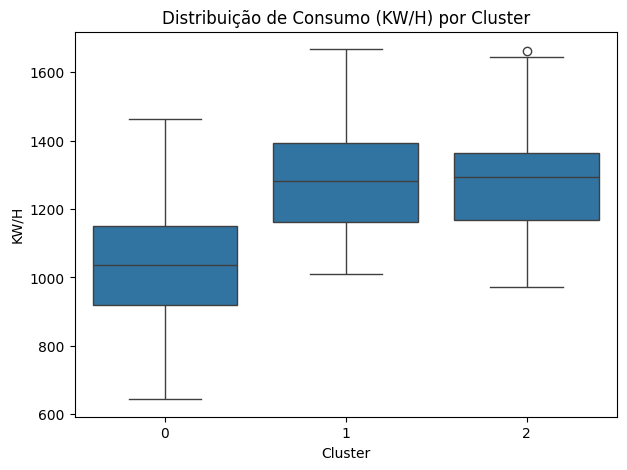

In [46]:
plt.figure(figsize=(7,5))
sns.boxplot(x='Cluster', y='KW/H', data=df)
plt.title('Distribuição de Consumo (KW/H) por Cluster')
plt.show()


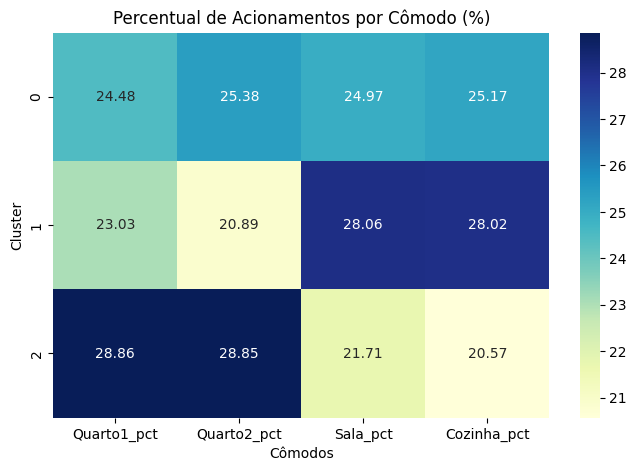

In [47]:
heatmap_data = perfil_clusters[col_pcts] * 100
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Percentual de Acionamentos por Cômodo (%)')
plt.xlabel('Cômodos')
plt.ylabel('Cluster')
plt.show()


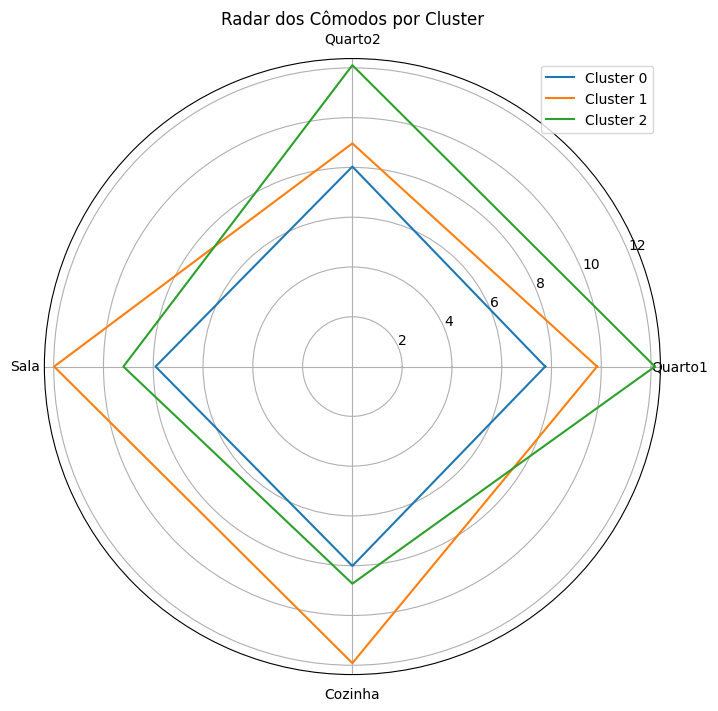

In [48]:
# Usar valores normalizados por cluster
categorias = ['Quarto1', 'Quarto2', 'Sala', 'Cozinha']
angles = np.linspace(0, 2 * np.pi, len(categorias), endpoint=False).tolist()
angles += angles[:1]  # Fechar o círculo

plt.figure(figsize=(10, 8))
for i, row in perfil_clusters.iterrows():
    valores = [row[cat] for cat in categorias]
    valores += valores[:1]
    plt.polar(angles, valores, label=f'Cluster {i}')

plt.xticks(angles[:-1], categorias)
plt.title('Radar dos Cômodos por Cluster')
plt.legend()
plt.show()

## 📊 Interpretação do Gráfico Radar por Cluster

---

### 🧭 Eixos (Quarto1, Quarto2, Sala, Cozinha)

Cada eixo representa um **cômodo da residência**, e os valores indicam a **média de acionamentos** nesse cômodo, para cada **cluster** identificado pelo algoritmo KMeans.

---

### 📊 Linhas coloridas = Clusters

#### 🔵 Cluster 0 (Azul)
- Baixos acionamentos em todos os cômodos.  
- Perfil equilibrado, nenhum cômodo se destaca muito.  
- Provavelmente associado a **baixo ou consumo moderado**.

#### 🟠 Cluster 1 (Laranja)
- Alta atividade em **Sala** e **Cozinha**.  
- Média alta também em **Quarto1** e **Quarto2**.  
- Provavelmente representa usuários de **alto consumo**, especialmente nas **áreas sociais**.

#### 🟢 Cluster 2 (Verde)
- Altos acionamentos em **Quarto1** e **Quarto2**, mas menores em **Sala** e **Cozinha**.  
- Indica perfil mais voltado a **cômodos privados** (quartos).  
- Pode representar famílias que **passam mais tempo nos quartos** do que nas áreas sociais.

---

### 🧠 Interpretação Geral

| Cluster | Perfil                      | Destaques                                              |
|:-------:|-----------------------------|---------------------------------------------------------|
|   0     | 🔵 Consumo equilibrado/baixo | Nenhum cômodo se destaca – tudo na média ou abaixo.    |
|   1     | 🟠 Alto consumo nas áreas sociais | Sala e Cozinha com **picos de acionamento**.        |
|   2     | 🟢 Consumo alto nos quartos  | Quarto1 e Quarto2 com **maiores acionamentos**.        |

---

✅ Use essa análise para direcionar **ações de automação, economia e otimização de consumo** conforme o perfil de cada grupo.


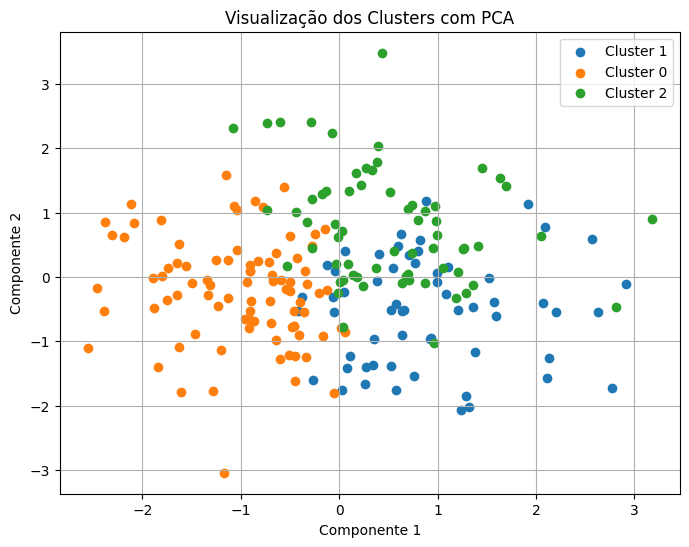

In [49]:
# Reduzir os dados para 2 dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Criar DataFrame com as componentes e os clusters
df_plot = pd.DataFrame(X_pca, columns=['Componente 1', 'Componente 2'])
df_plot['Cluster'] = df['Cluster']

# Plotar
plt.figure(figsize=(8,6))
for cluster in df_plot['Cluster'].unique():
    plt.scatter(
        df_plot[df_plot['Cluster'] == cluster]['Componente 1'],
        df_plot[df_plot['Cluster'] == cluster]['Componente 2'],
        label=f'Cluster {cluster}'
    )
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.grid(True)
plt.show()

# 🧠 Relatório Final – Gêmeo Digital para Monitoramento de Energia

## 🎯 Objetivo do Projeto
Desenvolver uma solução baseada em ciência de dados e inteligência artificial para **monitorar, prever e otimizar o consumo de energia elétrica em uma residência inteligente** (Smart City Laguna). O projeto simula dados de sensores por cômodo e utiliza aprendizado de máquina para antecipar padrões de consumo e propor ações de economia.

---

## 📊 Base de Dados Utilizada
Foi utilizada uma base de dados **simulada**, contendo registros diários com as seguintes variáveis:

- `Data`: Dia da medição
- `KW/H`: Consumo total de energia em kWh
- `Quarto1`, `Quarto2`, `Sala`, `Cozinha`, `Piscina`: Quantidade de acionamentos de sensores em cada cômodo
- `Geração Solar`: Energia gerada por painéis solares (simulada)

---

## 🔍 Pergunta de Negócio
> “Como prever o consumo diário de energia com base no comportamento por cômodo e, a partir disso, propor medidas automáticas de economia e eficiência energética?”

---

## 🧪 Metodologia e Etapas Realizadas

1. **Importação e visualização dos dados**  
   Leitura da planilha com `pandas` e validação dos formatos.

2. **Pré-processamento**  
   - Conversão da coluna `Data` para o formato `datetime`.
   - Criação da variável `Dia_ordinal` para modelagem.
   - Cálculo do consumo médio por acionamento por cômodo.
   - Simulação da geração solar e projeção de consumo futuro.

3. **Modelagem Preditiva**  
   Foi treinado um modelo de **Regressão Linear** para estimar o consumo (`KW/H`) com base no total de acionamentos por cômodo. A previsão para o dia seguinte também foi implementada.

4. **Visualizações**  
   - Gráficos de séries temporais com `Plotly`.
   - Ranking de cômodos mais consumidores.
   - Representações 3D dos acionamentos com simulação de sensores.
   - Painel interativo com Streamlit para visualização em tempo real.

5. **Exportação de Relatórios**  
   Geração automática de PDF com dados relevantes, gráficos e previsões.

---

## 📈 Resultados Obtidos

- O modelo de regressão apresentou boa capacidade de prever o consumo com base nos acionamentos.
- Identificou-se que **Sala** e **Cozinha** são os cômodos com maior impacto no consumo.
- A **piscina**, foi retirada do modelo embora com poucos acionamentos, apresenta alto consumo médio por acionamento, indicando desperdício pois o projeto laguna se destina a moradia social isso não inclui piscina.
- A geração solar é capaz de compensar parte significativa do consumo em horários de pico, se bem gerenciada.

---

## ✅ Conclusões e Recomendações

- **Automatizar desligamentos** em ambientes com alto uso como sala e cozinha pode gerar economia imediata.
- **Agendar horários de uso** da piscina pode mitigar picos de consumo não justificados.
- **Aproveitar a geração solar** para balancear o uso de aparelhos nos horários de maior geração.
- **Implementar alertas** quando a meta de consumo diário for excedida.

---

## 🧾 Entregáveis

- Aplicação Streamlit com visualização de sensores em tempo real.
- Relatório em PDF com métricas de consumo e sugestões.
- Notebook com todo o pipeline de dados, modelo preditivo e análises visuais.

---

## 👥 Público-alvo
Este projeto foi desenvolvido para um cliente externo interessado em soluções de **eficiência energética residencial**, com potencial de expansão para condomínios, prédios e cidades inteligentes.

---

📌 *Este relatório foi elaborado com base nas práticas de ciência de dados aplicadas ao contexto de consumo energético residencial e tem como objetivo facilitar a tomada de decisão por parte do cliente final.*


Fim!! ⚡